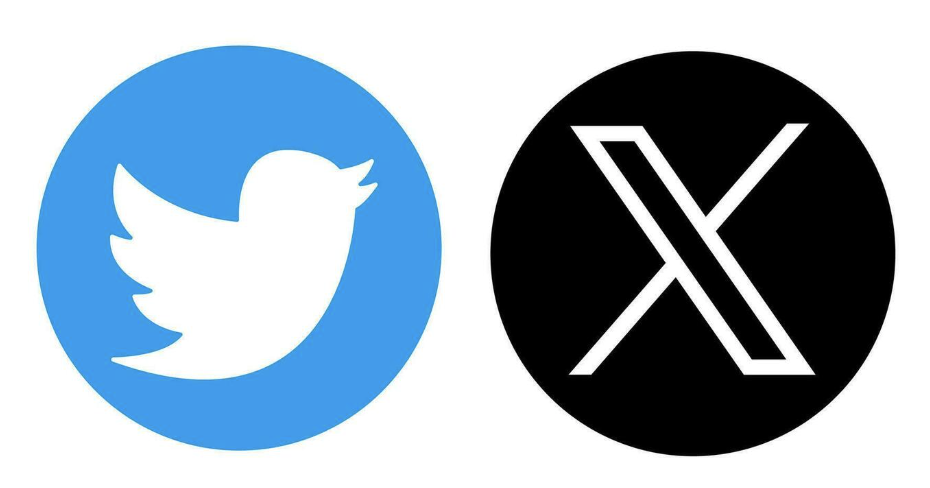

---

**Problem Statement**

Twitter is a microblogging and social networking service on which users post and interact with messages known as "tweets". Every second, on average, around 6,000 tweets are tweeted on Twitter, corresponding to over 350,000 tweets sent per minute, 500 million tweets per day.

Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.

Named Entity Recognition (NER) is an important subtask of information extraction that seeks to locate and recognise named entities.

We need to train models that will be able to identify the various named entities.

---

**Dataset Description**

Dataset is annotated with 10 fine-grained NER categories: person, geo-location, company, facility, product,music artist, movie, sports team, tv show and other. Dataset was extracted from tweets and is structured in CoNLL format., in English language. Containing in Text file format.

The CoNLL format is a text file with one word per line with sentences separated by an empty line. The first word in a line should be the word and the last word should be the label.


---

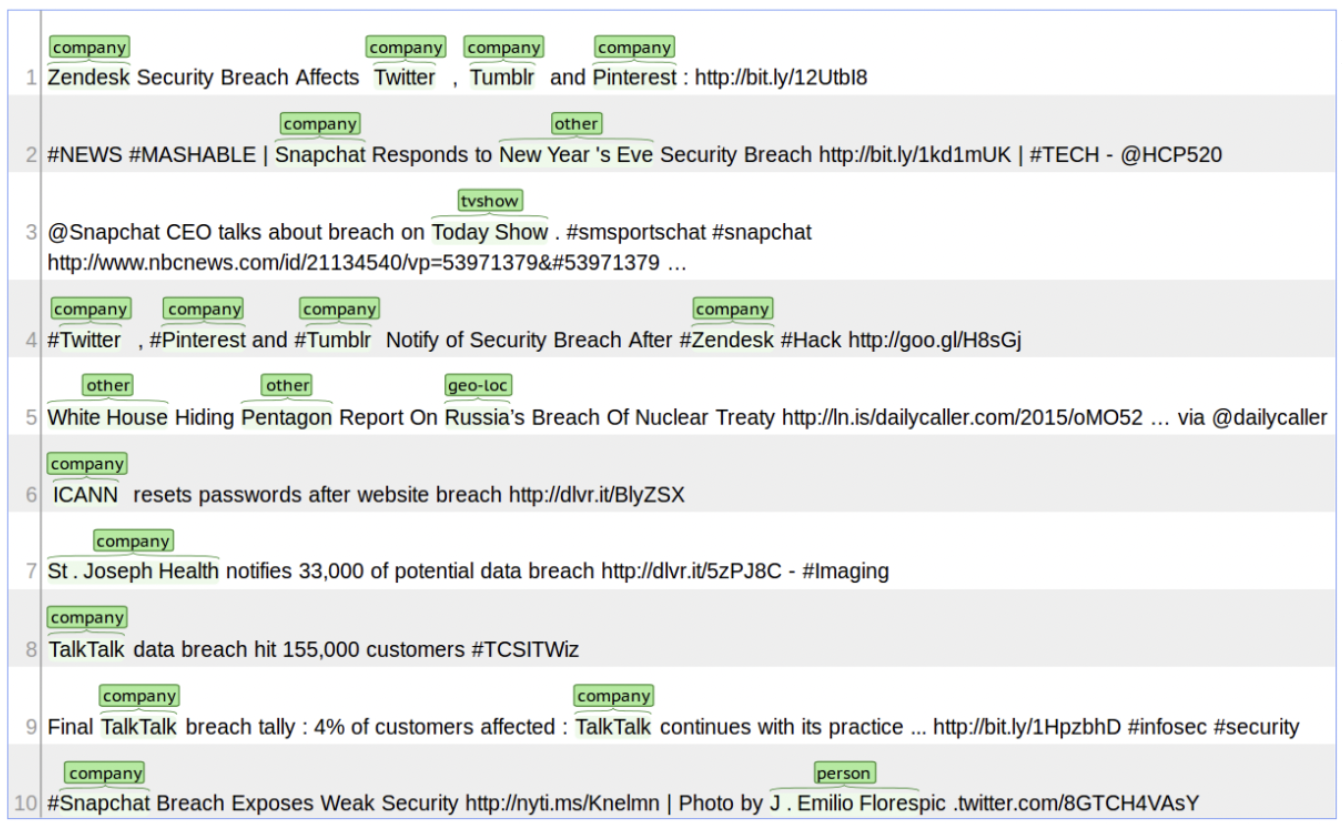

#Load and Install

##Import Installations

In [1]:
!pip install tf2crf
!pip install --upgrade tensorflow==2.13.0
!pip install --upgrade keras==2.13.1
!pip install --upgrade tensorflow-addons
!pip install fasttext
!pip install seqeval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313471 sha256=4f901a9305290776ee79f3a5ac224fa9a94b9475bac81dd2cd97d1b42efcd35f
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=3d8cada7bf384765eeddf0474e37022b916af19ae8e48bf91bbad6e11e2c7b59
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a

##Load Dataset

In [2]:
!gdown 1Q2al5TG4GDDsuVuTbmnbknjjZUbcuAZH
!gdown 1AKeYlFbQ-_RevBKapJz6C2pW9TSAxsQL

Downloading...
From: https://drive.google.com/uc?id=1Q2al5TG4GDDsuVuTbmnbknjjZUbcuAZH
To: /content/wnut 16.txt.conll
100% 403k/403k [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AKeYlFbQ-_RevBKapJz6C2pW9TSAxsQL
To: /content/wnut 16test.txt.conll
100% 635k/635k [00:00<00:00, 106MB/s]


In [3]:
# Block 2: Import Libraries and Load the Dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

# Function to read CoNLL formatted file
def read_conll_data(filepath):
    sentences = []
    sentence = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.strip() == '':
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                splits = line.strip().split()
                word = splits[0]
                tag = splits[-1]
                sentence.append((word, tag))
        if sentence:
            sentences.append(sentence)
    return sentences

# Load the datasets
train_sentences = read_conll_data('wnut 16.txt.conll')
test_sentences = read_conll_data('wnut 16test.txt.conll')

print("Number of training sentences:", len(train_sentences))
print("Example training sentence:", train_sentences[0])

Number of training sentences: 2394
Example training sentence: [('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]


#Exploratory Data Analysis

##Total and Unique words

In [4]:
# Block 3: Exploratory Data Analysis

# Flatten the list of sentences into a list of words and tags
all_words = [word for sentence in train_sentences for word, tag in sentence]
all_tags = [tag for sentence in train_sentences for word, tag in sentence]

print("Total words:", len(all_words))
print("Unique words:", len(set(all_words)))
print("Tag distribution:")
print(dict(Counter(all_tags)))

Total words: 46469
Unique words: 10586
Tag distribution:
{'O': 44007, 'B-geo-loc': 276, 'B-facility': 104, 'I-facility': 105, 'B-movie': 34, 'I-movie': 46, 'B-company': 171, 'B-product': 97, 'B-person': 449, 'B-other': 225, 'I-other': 320, 'B-sportsteam': 51, 'I-sportsteam': 23, 'I-product': 80, 'I-company': 36, 'I-person': 215, 'I-geo-loc': 49, 'B-tvshow': 34, 'B-musicartist': 55, 'I-musicartist': 61, 'I-tvshow': 31}


##Plot NER Tag Distribution

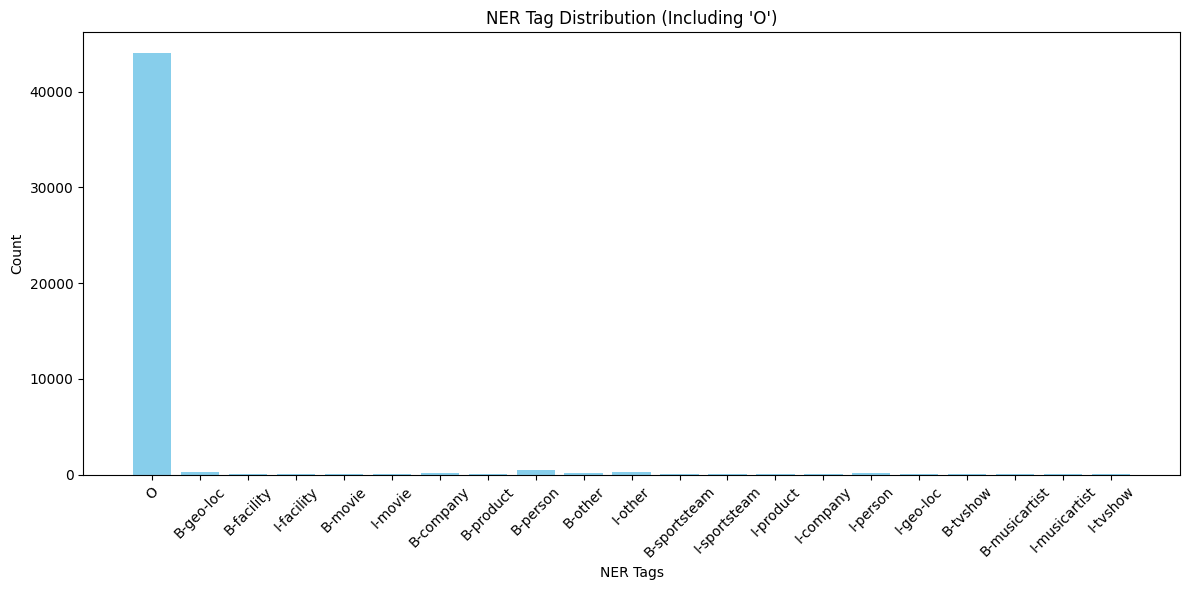

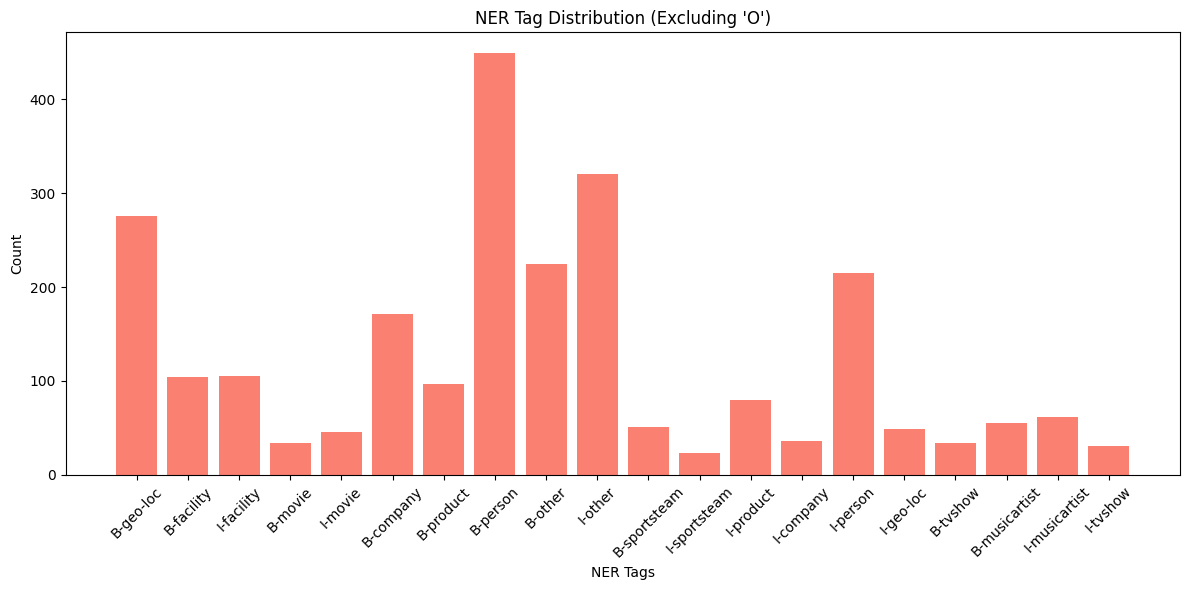

In [5]:
# Block 4: Plot NER Tag Distribution

import matplotlib.pyplot as plt

# Calculate tag distribution using the Counter from Block 3
tag_counts = dict(Counter(all_tags))

# Plot 1: NER Tag Distribution including 'O'
plt.figure(figsize=(12, 6))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.title("NER Tag Distribution (Including 'O')")
plt.xlabel("NER Tags")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: NER Tag Distribution excluding 'O'
tag_counts_no_O = {tag: count for tag, count in tag_counts.items() if tag != 'O'}

plt.figure(figsize=(12, 6))
plt.bar(tag_counts_no_O.keys(), tag_counts_no_O.values(), color='salmon')
plt.title("NER Tag Distribution (Excluding 'O')")
plt.xlabel("NER Tags")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Preprocessing

##Vocabulary and Label Mapping

In [6]:
# Block 5: Data Preprocessing - Vocabulary and Label Mapping

# Collect all unique words and tags from the training sentences
words = set()
tags = set()
for sentence in train_sentences:
    for word, tag in sentence:
        words.add(word)
        tags.add(tag)

words = sorted(list(words))
tags = sorted(list(tags))

# Create mapping dictionaries.
# For words, reserve index 0 for padding and index 1 for unknown words.
word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["UNK"] = 1  # unknown token
idx2word = {i: w for w, i in word2idx.items()}

# For tags, reserve 0 for padding.
tag2idx = {t: i+1 for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

print("Vocabulary size:", len(word2idx))
print("Number of tags:", len(tag2idx))

Vocabulary size: 10587
Number of tags: 21


##Convert Sentences to Sequences and Pad Them

In [7]:
# Block 6: Convert Sentences to Sequences and Pad Them using a computed max_len

# Calculate max_len based on the longest sentence in the training dataset
max_len = max(len(sentence) for sentence in train_sentences)
print("Calculated max_len:", max_len)

def encode_sentences(sentences, word2idx, tag2idx, max_len):
    X = []
    y = []
    for sentence in sentences:
        # Convert words and tags to their corresponding indices
        seq_words = [word2idx.get(word, word2idx["UNK"]) for word, tag in sentence]
        seq_tags = [tag2idx[tag] for word, tag in sentence]
        X.append(seq_words)
        y.append(seq_tags)
    # Pad sequences to the computed maximum length
    X = pad_sequences(X, maxlen=max_len, padding='post', value=0)
    y = pad_sequences(y, maxlen=max_len, padding='post', value=0)
    return X, y

# Encode the training and test sentences using the computed max_len
X, y = encode_sentences(train_sentences, word2idx, tag2idx, max_len)
X_test, y_test = encode_sentences(test_sentences, word2idx, tag2idx, max_len)

# Split a portion of the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Calculated max_len: 39
Shape of X_train: (2154, 39)
Shape of y_train: (2154, 39)


##Imbalance Treatment

##Compute Class Weights

In [8]:
# Block 7A: Compute Class Weights for Handling Imbalance

import tensorflow as tf
# Flatten y_train (ignoring padding which is 0)
y_train_flat = y_train[y_train != 0]

# Compute frequency counts for each label (labels are integers > 0)
unique, counts = np.unique(y_train_flat, return_counts=True)
freq_dict = dict(zip(unique, counts))
total_count = np.sum(counts)
num_classes = len(tag2idx)  # number of actual entity labels (indices 1 ... num_classes)

# Compute initial weights: common formula is weight = total_count / (count for that class)
class_weights = {}
for i in range(1, num_classes + 1):
    # If a class is missing (shouldn't happen), assign default weight 1.0
    class_weights[i] = total_count / freq_dict.get(i, 1)

# Normalize weights so that the average weight is 1.0
avg_weight = np.mean(list(class_weights.values()))
for k in class_weights:
    class_weights[k] = class_weights[k] / avg_weight

# Create a weight vector of shape (num_labels,) where index 0 (padding) gets weight 0.
cw = np.zeros(num_classes + 1)
cw[0] = 0.0  # padding token weight
for i in range(1, num_classes + 1):
    cw[i] = class_weights[i]

# Convert to a TensorFlow constant.
class_weights_tensor = tf.constant(cw, dtype=tf.float32)

print("Computed class weights:", class_weights_tensor.numpy())

Computed class weights: [0.0000000e+00 3.9959928e-01 6.1381745e-01 2.4203372e-01 1.8606342e+00
 1.1025981e+00 2.9475394e-01 1.4665097e-01 7.0881301e-01 1.2151080e+00
 1.9206547e+00 1.8606342e+00 6.0755402e-01 1.4176260e+00 1.3846580e+00
 1.0091575e+00 2.0531136e-01 3.1336996e-01 8.7559259e-01 2.8352520e+00
 1.9846765e+00 1.5042266e-03]


#LSTM + CRF Model

##Build the Custom LSTM+CRF Model

In [9]:
# Block 7B: Build the Custom LSTM+CRF Model with Class Imbalance Handling

import tensorflow_addons as tfa
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model

class CRFModel(tf.keras.Model):
    def __init__(self, vocab_size, num_labels, embedding_dim, lstm_units, max_len, class_weights, **kwargs):
        super(CRFModel, self).__init__(**kwargs)
        self.max_len = max_len
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            mask_zero=True,
            name='Embedding_Layer'
        )
        self.bilstm = Bidirectional(
            LSTM(
                units=lstm_units,
                return_sequences=True,
                dropout=0.5,
                recurrent_dropout=0.5,
                name='LSTM_Layer'
            ),
            name='BiLSTM_Layer'
        )
        self.dense = TimeDistributed(
            Dense(num_labels),
            name='TimeDistributed_Dense'
        )
        # Trainable CRF transition matrix.
        self.transitions = self.add_weight(
            shape=(num_labels, num_labels),
            initializer="glorot_uniform",
            trainable=True,
            name="CRF_Transitions"
        )
        self.class_weights = class_weights  # Tensor of shape (num_labels,)

    def call(self, inputs, training=None):
        # Create a boolean mask: padding tokens are assumed to be 0.
        mask = tf.cast(tf.not_equal(inputs, 0), tf.bool)
        x = self.embedding(inputs)
        x = self.bilstm(x, mask=mask, training=training)
        logits = self.dense(x)
        return logits, mask

    def crf_loss(self, y_true, logits, mask):
        # Compute sequence lengths from the mask.
        sequence_lengths = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        # Compute CRF log-likelihood (per sequence).
        log_likelihood, _ = tfa.text.crf_log_likelihood(logits, y_true, sequence_lengths, transition_params=self.transitions)

        # --- Incorporate Class Weights ---
        # Convert y_true to int32 and look up token weights.
        y_true_int = tf.cast(y_true, tf.int32)
        token_weights = tf.gather(self.class_weights, y_true_int)  # shape: (batch, max_len)
        token_weights = token_weights * tf.cast(mask, tf.float32)  # zero out padding positions

        # Compute average weight per sequence (avoiding division by zero)
        seq_weight = tf.math.divide_no_nan(
            tf.reduce_sum(token_weights, axis=1),
            tf.reduce_sum(tf.cast(mask, tf.float32), axis=1)
        )

        # Multiply the log-likelihood for each sequence by its weight
        weighted_log_likelihood = log_likelihood * seq_weight
        loss = -tf.reduce_mean(weighted_log_likelihood)
        return loss

    def decode(self, logits, mask):
        sequence_lengths = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        viterbi_seq, _ = tfa.text.crf_decode(logits, self.transitions, sequence_lengths)
        return viterbi_seq

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            logits, mask = self(x, training=True)
            loss = self.crf_loss(y, logits, mask)
            loss += sum(self.losses)  # add regularization losses if any
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        x, y = data
        logits, mask = self(x, training=False)
        loss = self.crf_loss(y, logits, mask)
        return {"loss": loss}

# Define model parameters using your precomputed variables.
vocab_size = len(word2idx) + 1
num_labels = len(tag2idx) + 1
embedding_dim = 100
lstm_units = 100

# Instantiate and compile the model with class weights.
crf_model = CRFModel(vocab_size, num_labels, embedding_dim, lstm_units, max_len, class_weights=class_weights_tensor)
crf_model.compile(optimizer='adam')
crf_model.build(input_shape=(None, max_len))
crf_model.summary()

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "crf_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  multiple                  1058800   
 )                                                               
                                                                 
 BiLSTM_Layer (Bidirectiona  multiple                  160800    
 l)                                                              
                                                                 
 TimeDistributed_Dense (Tim  multiple                  4422      
 eDistributed)                                                   
                                                                 
Total params: 1224506 (4.67 MB)
Trainable params: 1224506 (4.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##Training the Model

In [19]:
# Block 8(optional): Train the Model without class weights
history = crf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10
)

Epoch 1/10
68/68 [==============================] - 29s 273ms/step - loss: 19.5920 - val_loss: 9.6673
Epoch 2/10
68/68 [==============================] - 16s 238ms/step - loss: 7.4232 - val_loss: 9.0523
Epoch 3/10
68/68 [==============================] - 16s 238ms/step - loss: 6.0361 - val_loss: 8.2891
Epoch 4/10
68/68 [==============================] - 18s 259ms/step - loss: 4.7889 - val_loss: 7.7139
Epoch 5/10
68/68 [==============================] - 16s 241ms/step - loss: 3.9344 - val_loss: 7.8987
Epoch 6/10
68/68 [==============================] - 16s 240ms/step - loss: 3.3906 - val_loss: 7.9276
Epoch 7/10
68/68 [==============================] - 17s 249ms/step - loss: 3.0399 - val_loss: 7.9466
Epoch 8/10
68/68 [==============================] - 17s 247ms/step - loss: 2.8678 - val_loss: 8.2104
Epoch 9/10
68/68 [==============================] - 16s 240ms/step - loss: 2.7009 - val_loss: 8.2432
Epoch 10/10
68/68 [==============================] - 16s 240ms/step - loss: 2.5879 - val_l

In [10]:
# Block 8: Train the Custom LSTM+CRF Model with Class Weights

history = crf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)

Epoch 1/5
68/68 [==============================] - 37s 377ms/step - loss: 0.9217 - val_loss: 0.7665
Epoch 2/5
68/68 [==============================] - 18s 265ms/step - loss: 0.6508 - val_loss: 0.7203
Epoch 3/5
68/68 [==============================] - 19s 279ms/step - loss: 0.5853 - val_loss: 0.6808
Epoch 4/5
68/68 [==============================] - 19s 279ms/step - loss: 0.5021 - val_loss: 0.6350
Epoch 5/5
68/68 [==============================] - 19s 275ms/step - loss: 0.4182 - val_loss: 0.6244


##Make Predictions

In [24]:
# Block 9(optional): Make Predictions with the Custom CRF Model

def predict_crf(model, sentence):
    # Split the sentence into words
    words = sentence.split()
    # Convert words to indices using word2idx; use "UNK" for unknown words.
    seq = [word2idx.get(word, word2idx["UNK"]) for word in words]
    # Pad the sequence to max_len
    seq_padded = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=max_len, padding='post', value=0)
    # Get logits and mask from the model
    logits, mask = model(seq_padded, training=False)
    # Decode the best sequence using the CRF's Viterbi decoding
    pred_seq = model.decode(logits, mask)
    # Only consider predictions corresponding to the actual words (not padding)
    pred_seq = pred_seq.numpy()[0][:len(words)]
    # Convert predicted indices to tag labels using idx2tag
    pred_tags = [idx2tag.get(idx, 'O') for idx in pred_seq]
    return list(zip(words, pred_tags))

# Example prediction
sample_sentence = "Harry Potter was a student in London"
print("Predicted NER tags:")
print(predict_crf(crf_model, sample_sentence))

Predicted NER tags:
[('Harry', 'O'), ('Potter', 'O'), ('was', 'O'), ('a', 'O'), ('student', 'O'), ('in', 'O'), ('London', 'B-geo-loc')]


In [11]:
# Block 9: Make Predictions with the Custom CRF Model with weight adjusted loss function to address class imbalance

def predict_crf(model, sentence):
    # Split the sentence into words
    words = sentence.split()
    # Convert words to indices using word2idx; use "UNK" for unknown words.
    seq = [word2idx.get(word, word2idx["UNK"]) for word in words]
    # Pad the sequence to max_len
    seq_padded = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=max_len, padding='post', value=0)
    # Get logits and mask from the model
    logits, mask = model(seq_padded, training=False)
    # Decode the best sequence using the CRF's Viterbi decoding
    pred_seq = model.decode(logits, mask)
    # Only consider predictions corresponding to the actual words (not padding)
    pred_seq = pred_seq.numpy()[0][:len(words)]
    # Convert predicted indices to tag labels using idx2tag
    pred_tags = [idx2tag.get(idx, 'O') for idx in pred_seq]
    return list(zip(words, pred_tags))

# Example prediction
sample_sentence = "Harry Potter was a student in London"
print("Predicted NER tags:")
print(predict_crf(crf_model, sample_sentence))

Predicted NER tags:
[('Harry', 'O'), ('Potter', 'O'), ('was', 'O'), ('a', 'O'), ('student', 'O'), ('in', 'O'), ('London', 'B-facility')]


##Evaluate Model on Test Data

In [13]:
# Block 10: Evaluate Model on Test Data using seqeval with tqdm

from seqeval.metrics import classification_report, f1_score
from tqdm import tqdm

def decode_predictions(model, X, y_true_array, idx2tag, max_samples=None):
    predictions = []
    ground_truths = []

    # Optionally limit the number of samples (if max_samples is provided)
    n_samples = len(X) if max_samples is None else min(len(X), max_samples)

    for i in tqdm(range(n_samples), desc="Decoding predictions"):
        input_seq = X[i:i+1]  # shape: (1, max_len)
        logits, mask = model(input_seq, training=False)
        pred_seq = model.decode(logits, mask).numpy()[0]
        true_seq = y_true_array[i]  # corresponding true labels

        # Create a boolean mask for valid tokens (non-zero indices indicate actual tokens)
        valid_positions = (input_seq[0] != 0)
        # Convert predicted indices and true indices to tag strings, ignoring padding.
        pred_tags = [idx2tag.get(idx, 'O') for idx, valid in zip(pred_seq, valid_positions) if valid]
        true_tags = [idx2tag.get(idx, 'O') for idx, valid in zip(true_seq, valid_positions) if valid]

        predictions.append(pred_tags)
        ground_truths.append(true_tags)
    return predictions, ground_truths

# Optionally, evaluate on a subset (e.g., first 50 samples)
predictions, ground_truths = decode_predictions(crf_model, X_test, y_test, idx2tag, max_samples=50)

# Print performance metrics.
print("F1 Score:", f1_score(ground_truths, predictions))
print("Classification Report:")
print(classification_report(ground_truths, predictions))


Decoding predictions: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]

F1 Score: 0.0
Classification Report:
              precision    recall  f1-score   support

     company       0.00      0.00      0.00         8
    facility       0.00      0.00      0.00         2
     geo-loc       0.00      0.00      0.00        18
       movie       0.00      0.00      0.00         1
 musicartist       0.00      0.00      0.00         1
       other       0.00      0.00      0.00         8
      person       0.00      0.00      0.00         8
     product       0.00      0.00      0.00         8
  sportsteam       0.00      0.00      0.00         4

   micro avg       0.00      0.00      0.00        58
   macro avg       0.00      0.00      0.00        58
weighted avg       0.00      0.00      0.00        58




/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1. The evaluation report shows that the overall F1 score is very low.

2. Most of the entity types (except a very slight performance on "geo-loc") are not being detected well.

3. This suggests that—despite the improvements in loss—the model is still struggling to learn to recognize the less frequent entities due to severe class imbalance and possibly other factors in the data.

---

Next Steps:

<font size = '5'>Error Analysis & Fine-Tuning:


We'll perform error analysis (look at some misclassified examples) and then try further adjustments such as:

  - Tuning hyperparameters (learning rate, dropout, LSTM units, etc.).

  - Using techniques like focal loss which are designed for imbalanced classification.

##Error Analysis

In [14]:
# Block 11: Error Analysis on a Subset with Debug Prints

import time
from tqdm import tqdm

misclassified = []
subset_size = 20

for i in tqdm(range(subset_size), desc="Error analysis"):
    start_time = time.time()
    input_seq = X_test[i:i+1]  # shape: (1, max_len)

    # Get logits and mask from the model.
    logits, mask = crf_model(input_seq, training=False)

    # Decode the sequence
    try:
        pred_seq = crf_model.decode(logits, mask).numpy()[0]
    except Exception as e:
        print(f"Error decoding sample {i}: {e}")
        continue

    true_seq = y_test[i]  # corresponding true labels

    # Create a boolean mask for valid tokens (non-padding tokens)
    valid_positions = (input_seq[0] != 0)

    # Convert predicted indices and true indices to tag strings, ignoring padding.
    pred_tags = [idx2tag.get(idx, 'O') for idx, valid in zip(pred_seq, valid_positions) if valid]
    true_tags = [idx2tag.get(idx, 'O') for idx, valid in zip(true_seq, valid_positions) if valid]

    if pred_tags != true_tags:
        misclassified.append((i, pred_tags, true_tags))

    elapsed = time.time() - start_time
    print(f"Processed sample {i} in {elapsed:.2f} sec")

print("Total misclassified sentences:", len(misclassified))
for idx, pred, true in misclassified:
    sentence = " ".join([idx2word.get(token, "UNK") for token in X_test[idx] if token != 0])
    print("\nSentence:", sentence)
    print("True Tags:     ", true)
    print("Predicted Tags:", pred)

Error analysis:   5%|▌         | 1/20 [00:00<00:16,  1.16it/s]

Processed sample 0 in 0.86 sec


Error analysis:  10%|█         | 2/20 [00:01<00:17,  1.02it/s]

Processed sample 1 in 1.07 sec


Error analysis:  15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

Processed sample 2 in 1.22 sec


Error analysis:  20%|██        | 4/20 [00:04<00:17,  1.07s/it]

Processed sample 3 in 1.04 sec


Error analysis:  25%|██▌       | 5/20 [00:05<00:14,  1.01it/s]

Processed sample 4 in 0.85 sec


Error analysis:  30%|███       | 6/20 [00:05<00:13,  1.06it/s]

Processed sample 5 in 0.85 sec


Error analysis:  35%|███▌      | 7/20 [00:06<00:11,  1.10it/s]

Processed sample 6 in 0.83 sec


Error analysis:  40%|████      | 8/20 [00:07<00:10,  1.13it/s]

Processed sample 7 in 0.83 sec


Error analysis:  45%|████▌     | 9/20 [00:08<00:09,  1.15it/s]

Processed sample 8 in 0.83 sec


Error analysis:  50%|█████     | 10/20 [00:09<00:08,  1.18it/s]

Processed sample 9 in 0.79 sec


Error analysis:  55%|█████▌    | 11/20 [00:10<00:07,  1.18it/s]

Processed sample 10 in 0.84 sec


Error analysis:  60%|██████    | 12/20 [00:10<00:06,  1.19it/s]

Processed sample 11 in 0.83 sec


Error analysis:  65%|██████▌   | 13/20 [00:11<00:05,  1.19it/s]

Processed sample 12 in 0.83 sec


Error analysis:  70%|███████   | 14/20 [00:12<00:05,  1.20it/s]

Processed sample 13 in 0.83 sec


Error analysis:  75%|███████▌  | 15/20 [00:13<00:04,  1.22it/s]

Processed sample 14 in 0.79 sec


Error analysis:  80%|████████  | 16/20 [00:14<00:03,  1.16it/s]

Processed sample 15 in 0.96 sec


Error analysis:  85%|████████▌ | 17/20 [00:15<00:02,  1.04it/s]

Processed sample 16 in 1.17 sec


Error analysis:  90%|█████████ | 18/20 [00:16<00:02,  1.01s/it]

Processed sample 17 in 1.14 sec


Error analysis:  95%|█████████▌| 19/20 [00:17<00:00,  1.06it/s]

Processed sample 18 in 0.79 sec


Error analysis: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]

Processed sample 19 in 0.81 sec
Total misclassified sentences: 14

Sentence: New UNK UNK 's Day Parade shooting . One of the people hurt was a UNK girl . WHAT THE UNK IS UNK WITH UNK ?
True Tags:      ['B-other', 'I-other', 'I-other', 'I-other', 'I-other', 'I-other', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence: May e just a smile in your heart UNK UNK UNK
True Tags:      ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-movie', 'O', 'O']
Predicted Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence: I could so do Thursday Club right now
True Tags:      ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Tags: ['O', 'O', 'O', 'O', 'O', 'B-person', 'O', 'O']

Sentence: UNK UNK UNK ( UNK UNK a woman living as a man in order to find work in the harsh UNK of UNK UNK
Tr

The error analysis output is revealing that the current model is struggling quite a bit with correctly predicting the entity labels.

Here are some key observations from your output:

1. Dominance of "O":
    - Most of the tokens are being predicted as "O", which is common in NER tasks with severe class imbalance. This confirms that the model is biased toward the majority class.

2. Misclassifications:
    - Several examples show that when the true tags indicate an entity (e.g., "B-person", "B-other", etc.), the model either predicts "O" or a completely different label.
    
    - For instance, in one example, the model predicts all "O" even though there are non-"O" tags in the ground truth, while in another, it incorrectly tags a token as "I-other" or "B-other" when the true label might be something else.

3. Processing Time:
  - Each sample is processed in about 0.8-1.2 seconds on average.
  
  - This is acceptable given the complexity of CRF decoding, though it does highlight that evaluation can be time-consuming on large datasets.

---

These insights tell us that:

1.  The error analysis block is correctly identifying misclassified examples.

2.  Our model still has significant room for improvement.

3.  Let's explore further hyperparameter tuning (e.g., adjusting the learning rate, dropout rates, or LSTM units).

4.  Alwo, we'll consider using advanced loss functions like focal loss to help with the class imbalance.

##Tuning Learning Rate

In [15]:
# Block 12a: Tuning Learning Rate

from tensorflow.keras.optimizers import Adam

# Trying a smaller learning rate (e.g., 1e-4)
tuned_lr = 1e-4
crf_model.compile(optimizer=Adam(learning_rate=tuned_lr))
history_tuned_lr = crf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)

Epoch 1/5
68/68 [==============================] - 47s 290ms/step - loss: 0.3772 - val_loss: 0.6389
Epoch 2/5
68/68 [==============================] - 20s 295ms/step - loss: 0.3714 - val_loss: 0.6415
Epoch 3/5
68/68 [==============================] - 19s 276ms/step - loss: 0.3601 - val_loss: 0.6385
Epoch 4/5
68/68 [==============================] - 21s 307ms/step - loss: 0.3563 - val_loss: 0.6497
Epoch 5/5
68/68 [==============================] - 19s 272ms/step - loss: 0.3521 - val_loss: 0.6467


##Re-evaluate on a subset

In [16]:
# Re-evaluate on a subset (e.g., first 50 samples)
predictions, ground_truths = decode_predictions(crf_model, X_test, y_test, idx2tag, max_samples=50)

# Print performance metrics.
print("F1 Score:", f1_score(ground_truths, predictions))
print("Classification Report:")
print(classification_report(ground_truths, predictions))

Decoding predictions: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]

F1 Score: 0.027397260273972605
Classification Report:
              precision    recall  f1-score   support

     company       0.00      0.00      0.00         8
    facility       0.00      0.00      0.00         2
     geo-loc       0.50      0.06      0.10        18
       movie       0.00      0.00      0.00         1
 musicartist       0.00      0.00      0.00         1
       other       0.00      0.00      0.00         8
      person       0.00      0.00      0.00         8
     product       0.00      0.00      0.00         8
  sportsteam       0.00      0.00      0.00         4

   micro avg       0.07      0.02      0.03        58
   macro avg       0.06      0.01      0.01        58
weighted avg       0.16      0.02      0.03        58



This is still not so good performance

##Rebuilding the Model

In [17]:
# Block 12b: Rebuilding the Model with Modified Hyperparameters

from tensorflow.keras.optimizers import Adam

# Define new hyperparameters.
new_lstm_units = 150
new_dropout = 0.4
new_recurrent_dropout = 0.4

# Define a new CRF model with the modified hyperparameters.
class CRFModelTuned(tf.keras.Model):
    def __init__(self, vocab_size, num_labels, embedding_dim, lstm_units, max_len, class_weights, **kwargs):
        super(CRFModelTuned, self).__init__(**kwargs)
        self.max_len = max_len
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   mask_zero=True,
                                   name='Embedding_Layer')
        self.bilstm = Bidirectional(
            LSTM(units=lstm_units,
                 return_sequences=True,
                 dropout=new_dropout,
                 recurrent_dropout=new_recurrent_dropout,
                 name='LSTM_Layer'),
            name='BiLSTM_Layer')
        self.dense = TimeDistributed(Dense(num_labels), name='TimeDistributed_Dense')
        self.transitions = self.add_weight(shape=(num_labels, num_labels),
                                           initializer="glorot_uniform",
                                           trainable=True,
                                           name="CRF_Transitions")
        self.class_weights = class_weights

    def call(self, inputs, training=None):
        mask = tf.cast(tf.not_equal(inputs, 0), tf.bool)
        x = self.embedding(inputs)
        x = self.bilstm(x, mask=mask, training=training)
        logits = self.dense(x)
        return logits, mask

    def crf_loss(self, y_true, logits, mask):
        sequence_lengths = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        log_likelihood, _ = tfa.text.crf_log_likelihood(logits, y_true, sequence_lengths,
                                                        transition_params=self.transitions)
        return -tf.reduce_mean(log_likelihood)

    def decode(self, logits, mask):
        sequence_lengths = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        viterbi_seq, _ = tfa.text.crf_decode(logits, self.transitions, sequence_lengths)
        return viterbi_seq

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            logits, mask = self(x, training=True)
            loss = self.crf_loss(y, logits, mask)
            loss += sum(self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        x, y = data
        logits, mask = self(x, training=False)
        loss = self.crf_loss(y, logits, mask)
        return {"loss": loss}

# Instantiate and compile the tuned model.
crf_model_tuned = CRFModelTuned(vocab_size, num_labels, embedding_dim, new_lstm_units, max_len, class_weights=class_weights_tensor)
crf_model_tuned.compile(optimizer=Adam(learning_rate=1e-4))
crf_model_tuned.build(input_shape=(None, max_len))
crf_model_tuned.summary()

history_tuned = crf_model_tuned.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)

Model: "crf_model_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  multiple                  1058800   
 )                                                               
                                                                 
 BiLSTM_Layer (Bidirectiona  multiple                  301200    
 l)                                                              
                                                                 
 TimeDistributed_Dense (Tim  multiple                  6622      
 eDistributed)                                                   
                                                                 
Total params: 1367106 (5.22 MB)
Trainable params: 1367106 (5.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
68/68 [==============================] - 40s 415ms/step - loss: 60.30

In [18]:
# Re-evaluate on a subset (e.g., first 50 samples)
predictions, ground_truths = decode_predictions(crf_model_tuned, X_test, y_test, idx2tag, max_samples=50)

# Print performance metrics.
print("F1 Score:", f1_score(ground_truths, predictions))
print("Classification Report:")
print(classification_report(ground_truths, predictions))

Decoding predictions: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]

F1 Score: 0.0
Classification Report:
              precision    recall  f1-score   support

     company       0.00      0.00      0.00         8
    facility       0.00      0.00      0.00         2
     geo-loc       0.00      0.00      0.00        18
       movie       0.00      0.00      0.00         1
 musicartist       0.00      0.00      0.00         1
       other       0.00      0.00      0.00         8
      person       0.00      0.00      0.00         8
     product       0.00      0.00      0.00         8
  sportsteam       0.00      0.00      0.00         4

   micro avg       0.00      0.00      0.00        58
   macro avg       0.00      0.00      0.00        58
weighted avg       0.00      0.00      0.00        58



This too isn't good either

---
<font size='5'>
Summary

1. Current Findings:
  - The CRF-based model, even with focal loss and class weighting, yields very low F1 scores, indicating that the model is still heavily biased toward predicting non-entities ("O").

2. Next Step:
  - Switching to a transformer-based model (BERT in this case) is our next move.
  - BERT has been shown to capture context and entity boundaries much better, even in imbalanced settings.

#BERT Based Model

##Fine-tuning a BERT-Based Model for NER with a Custom Loss Function

In [29]:
# Block 14 (BERT Fine-Tuning with run_eagerly):
# Fine-tuning a BERT-Based Model for NER with a Custom Loss Function

from transformers import TFBertForTokenClassification, BertTokenizerFast
import tensorflow as tf

# Load the BERT tokenizer and model.
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# The number of labels should match the tag set (len(tag2idx)+1).
num_labels_transformer = num_labels  # using previously defined num_labels

# Load the pre-trained BERT model for token classification.
model_bert = TFBertForTokenClassification.from_pretrained(model_name, num_labels=num_labels_transformer)

def tokenize_and_align_labels(sentences, tokenizer, tag2idx, max_len):
    tokenized_inputs = []
    labels_list = []
    for sentence in sentences:
        words = [w for w, t in sentence]
        tags = [t for w, t in sentence]
        tokenized_input = tokenizer(
            words,
            is_split_into_words=True,
            truncation=True,
            max_length=max_len,
            padding='max_length'
        )
        # Align labels: assign -100 for tokens that don't correspond to a word.
        word_ids = tokenized_input.word_ids()
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(tag2idx[tags[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        tokenized_inputs.append(tokenized_input)
        labels_list.append(label_ids)
    return tokenized_inputs, labels_list

# Tokenize training and validation data.
train_tokenized, train_labels = tokenize_and_align_labels(train_sentences, tokenizer, tag2idx, max_len)
val_tokenized, val_labels = tokenize_and_align_labels(test_sentences, tokenizer, tag2idx, max_len)

def create_tf_dataset(tokenized_inputs, labels):
    input_ids = [ti['input_ids'] for ti in tokenized_inputs]
    attention_mask = [ti['attention_mask'] for ti in tokenized_inputs]
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': attention_mask},
        labels
    ))
    return dataset

train_dataset = create_tf_dataset(train_tokenized, train_labels).shuffle(1000).batch(16)
val_dataset = create_tf_dataset(val_tokenized, val_labels).batch(16)

# Define a custom loss function that ignores positions with label -100.
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # Create a mask for valid label positions.
    mask = tf.not_equal(y_true, -100)
    mask = tf.cast(mask, tf.float32)
    # Replace -100 with 0 so that the loss function doesn't error.
    y_true_mod = tf.where(tf.equal(y_true, -100), tf.zeros_like(y_true), y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_mod, y_pred, from_logits=True)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# Compile the model using optimizer as a string and force eager execution.
model_bert.compile(
    optimizer="adam",
    loss=masked_sparse_categorical_crossentropy,
    metrics=["accuracy"],
    run_eagerly=True
)

# Manually adjust the learning rate.
model_bert.optimizer.learning_rate.assign(3e-5)

# Fine-tune the model.
history_bert = model_bert.fit(train_dataset, epochs=3, validation_data=val_dataset)

# Save the fine-tuned model.
model_bert.save_pretrained("./bert_ner_model")
tokenizer.save_pretrained("./bert_ner_model")

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
150/150 [==============================] - 2646s 18s/step - loss: 0.3644 - accuracy: 0.4510 - val_loss: 0.4156 - val_accuracy: 0.3652
Epoch 2/3
150/150 [==============================] - 2399s 16s/step - loss: 0.1783 - accuracy: 0.4627 - val_loss: 0.3570 - val_accuracy: 0.3706
Epoch 3/3
150/150 [==============================] - 2434s 16s/step - loss: 0.1099 - accuracy: 0.4692 - val_loss: 0.3187 - val_accuracy: 0.3732


('./bert_ner_model/tokenizer_config.json',
 './bert_ner_model/special_tokens_map.json',
 './bert_ner_model/vocab.txt',
 './bert_ner_model/added_tokens.json',
 './bert_ner_model/tokenizer.json')

##Evaluation & Prediction

In [31]:
# Block 15: Evaluation & Prediction on a Subset of the Validation Data

from seqeval.metrics import classification_report, f1_score
from tqdm import tqdm
import tensorflow as tf

def decode_predictions_bert_subset(tokenized_inputs, model, idx2tag, max_samples=100):
    predictions = []
    for ti in tqdm(tokenized_inputs[:max_samples], desc="Decoding predictions"):
        input_ids = tf.constant([ti['input_ids']])
        attention_mask = tf.constant([ti['attention_mask']])
        outputs = model(input_ids, attention_mask=attention_mask)
        pred = tf.argmax(outputs.logits, axis=2).numpy()[0]
        word_ids = ti.word_ids()
        current_preds = []
        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue  # Skip special tokens.
            if word_idx != previous_word_idx:
                current_preds.append(idx2tag.get(pred[idx], "O"))
            previous_word_idx = word_idx
        predictions.append(current_preds)
    return predictions

def extract_true_labels_subset(tokenized_inputs, labels, idx2tag, max_samples=100):
    true_labels = []
    for ti, label_list in zip(tokenized_inputs[:max_samples], labels[:max_samples]):
        word_ids = ti.word_ids()
        current_labels = []
        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            if word_idx != previous_word_idx:
                if label_list[idx] != -100:
                    current_labels.append(idx2tag.get(label_list[idx], "O"))
            previous_word_idx = word_idx
        true_labels.append(current_labels)
    return true_labels

# Evaluation of first 100 samples.
max_samples = 100
bert_predictions_subset = decode_predictions_bert_subset(val_tokenized, model_bert, idx2tag, max_samples=max_samples)
ground_truths_subset = extract_true_labels_subset(val_tokenized, val_labels, idx2tag, max_samples=max_samples)

print("F1 Score (subset):", f1_score(ground_truths_subset, bert_predictions_subset))
print("Classification Report (subset):")
print(classification_report(ground_truths_subset, bert_predictions_subset))


Decoding predictions: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]

F1 Score (subset): 0.38043478260869573
Classification Report (subset):
              precision    recall  f1-score   support

     company       0.88      0.58      0.70        12
    facility       0.30      0.43      0.35         7
     geo-loc       0.72      0.46      0.57        28
       movie       0.00      0.00      0.00         1
 musicartist       0.00      0.00      0.00         6
       other       0.08      0.13      0.10        15
      person       0.56      0.67      0.61        15
     product       0.00      0.00      0.00        12
  sportsteam       0.00      0.00      0.00         4

   micro avg       0.42      0.35      0.38       100
   macro avg       0.28      0.25      0.26       100
weighted avg       0.42      0.35      0.37       100




/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The evaluation results show mixed performance:

- Overall F1 Score (subset): ~0.38
- Per-Class Performance:
  - Company: F1 ~0.70
  - Person: F1 ~0.61
  - Geo-loc: F1 ~0.57
  - Facility: F1 ~0.35

- Several classes (movie, musicartist, product, sportsteam) have F1 scores of 0, indicating that the model isn't predicting these at all.


**Interpretation**:

- An overall F1 score of 0.38 on a subset of 100 samples is an improvement over our earlier CRF-based models.

- The model performs well on some entity types (company, person, geo-loc), which is promising for downstream tasks like trend analysis or content tagging.

- However, it struggles with other classes, likely due to severe class imbalance and the inherent difficulty of NER on noisy Twitter data.

---
<font size = '5'>
Should We Proceed?

Yes: These results provide a baseline, and given the challenges with tweet data, they're a reasonable starting point.


**Next Steps:**

- Further Fine-Tuning: We could consider additional hyperparameter tuning or data augmentation to boost performance on underrepresented classes.

- Error Analysis: Review misclassified examples (especially for the zero-performing classes) to understand why the model isn't predicting those entities.


##Tuning

In [32]:
# Block 16a: Fine-Tuning with Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks.
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]

# Fine-tune the model using the same training and validation datasets.
history_bert_ft = model_bert.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/5
150/150 [==============================] - 2453s 16s/step - loss: 0.0712 - accuracy: 0.4739 - val_loss: 0.3109 - val_accuracy: 0.3737 - lr: 3.0000e-05
Epoch 2/5
150/150 [==============================] - 2455s 16s/step - loss: 0.0463 - accuracy: 0.4770 - val_loss: 0.3021 - val_accuracy: 0.3752 - lr: 3.0000e-05
Epoch 3/5
150/150 [==============================] - 2434s 16s/step - loss: 0.0299 - accuracy: 0.4795 - val_loss: 0.3596 - val_accuracy: 0.3753 - lr: 3.0000e-05
Epoch 4/5
150/150 [==============================] - 2464s 16s/step - loss: 0.0186 - accuracy: 0.4807 - val_loss: 0.3537 - val_accuracy: 0.3759 - lr: 1.5000e-05


##Oversample Minority Class

In [33]:
# Block 16b: Data Augmentation - Oversample Minority Class Sentences

# Define the set of minority classes based on evaluation.
minority_classes = {'movie', 'musicartist', 'product', 'sportsteam'}

def contains_minority(sentence, minority_classes):
    # Returns True if the sentence has at least one token labeled with a minority class.
    return any(label in minority_classes for word, label in sentence)

# Select training sentences that contain any minority entity.
oversample_sentences = [sentence for sentence in train_sentences if contains_minority(sentence, minority_classes)]
print("Number of minority sentences:", len(oversample_sentences))

# Oversample these sentences – for example, duplicate them twice.
augmented_train_sentences = train_sentences + oversample_sentences * 2

print("Original training sentences:", len(train_sentences))
print("Augmented training sentences:", len(augmented_train_sentences))

# Re-tokenize and re-create the training dataset using the augmented data.
train_tokenized_aug, train_labels_aug = tokenize_and_align_labels(augmented_train_sentences, tokenizer, tag2idx, max_len)
train_dataset_aug = create_tf_dataset(train_tokenized_aug, train_labels_aug).shuffle(1000).batch(16)

# Fine-tune the BERT model on the augmented dataset.
history_bert_aug = model_bert.fit(
    train_dataset_aug,
    epochs=3,
    validation_data=val_dataset,
    callbacks=callbacks
)

Number of minority sentences: 0
Original training sentences: 2394
Augmented training sentences: 2394
Epoch 1/3
150/150 [==============================] - 2464s 16s/step - loss: 0.0292 - accuracy: 0.4800 - val_loss: 0.3278 - val_accuracy: 0.3759 - lr: 7.5000e-06
Epoch 2/3
150/150 [==============================] - 2441s 16s/step - loss: 0.0221 - accuracy: 0.4808 - val_loss: 0.3447 - val_accuracy: 0.3759 - lr: 7.5000e-06
Epoch 3/3
150/150 [==============================] - 2468s 16s/step - loss: 0.0174 - accuracy: 0.4811 - val_loss: 0.3495 - val_accuracy: 0.3759 - lr: 3.7500e-06


##Evaluation & Example Prediction

In [34]:
# Block 17: Final Evaluation & Example Prediction

from seqeval.metrics import classification_report, f1_score
from tqdm import tqdm
import tensorflow as tf

def decode_predictions_bert_subset(tokenized_inputs, model, idx2tag, max_samples=100):
    """
    Decodes predictions from the BERT model for a subset of tokenized sentences,
    converting token-level predictions to word-level tags.
    """
    predictions = []
    for ti in tqdm(tokenized_inputs[:max_samples], desc="Decoding predictions"):
        input_ids = tf.constant([ti['input_ids']])
        attention_mask = tf.constant([ti['attention_mask']])
        outputs = model(input_ids, attention_mask=attention_mask)
        pred = tf.argmax(outputs.logits, axis=2).numpy()[0]
        word_ids = ti.word_ids()
        current_preds = []
        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue  # Skip special tokens.
            # Only label the first token of each word.
            if word_idx != previous_word_idx:
                current_preds.append(idx2tag.get(pred[idx], "O"))
            previous_word_idx = word_idx
        predictions.append(current_preds)
    return predictions

def extract_true_labels_subset(tokenized_inputs, labels, idx2tag, max_samples=100):
    """
    Extracts the true labels for each tokenized sentence, aligning them to word-level,
    ignoring subword labels marked as -100.
    """
    true_labels = []
    for ti, label_list in zip(tokenized_inputs[:max_samples], labels[:max_samples]):
        word_ids = ti.word_ids()
        current_labels = []
        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            if word_idx != previous_word_idx:
                if label_list[idx] != -100:
                    current_labels.append(idx2tag.get(label_list[idx], "O"))
            previous_word_idx = word_idx
        true_labels.append(current_labels)
    return true_labels

# Evaluate on a subset (first 100 samples).
max_samples = 100
predictions_subset = decode_predictions_bert_subset(val_tokenized, model_bert, idx2tag, max_samples)
true_labels_subset = extract_true_labels_subset(val_tokenized, val_labels, idx2tag, max_samples)

print("F1 Score (subset):", f1_score(true_labels_subset, predictions_subset))
print("Classification Report (subset):")
print(classification_report(true_labels_subset, predictions_subset))

# Example prediction function for a new sentence.
def ner_predict(sentence, model, tokenizer, idx2tag, max_len):
    """
    Takes a raw sentence (string), tokenizes it, and returns a list of (word, predicted_tag) tuples.
    """
    tokenized_input = tokenizer(
        sentence.split(),
        is_split_into_words=True,
        truncation=True,
        max_length=max_len,
        padding='max_length',
        return_tensors="tf"
    )
    outputs = model(tokenized_input.input_ids, attention_mask=tokenized_input.attention_mask)
    pred = tf.argmax(outputs.logits, axis=2).numpy()[0]
    word_ids = tokenized_input.word_ids()
    predictions = []
    previous_word_idx = None
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        if word_idx != previous_word_idx:
            predictions.append(idx2tag.get(pred[idx], "O"))
        previous_word_idx = word_idx
    # Zip the original words with their predicted tags.
    return list(zip(sentence.split(), predictions))

# Example usage:
example_sentence = "Barack Obama visited Berlin last week."
print("NER Prediction for example sentence:")
print(ner_predict(example_sentence, model_bert, tokenizer, idx2tag, max_len))

Decoding predictions: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


F1 Score (subset): 0.39583333333333337
Classification Report (subset):
              precision    recall  f1-score   support

     company       0.89      0.67      0.76        12
    facility       0.33      0.29      0.31         7
     geo-loc       0.63      0.43      0.51        28
       movie       0.00      0.00      0.00         1
 musicartist       1.00      0.17      0.29         6
       other       0.17      0.33      0.23        15
      person       0.47      0.60      0.53        15
     product       0.20      0.08      0.12        12
  sportsteam       0.00      0.00      0.00         4

   micro avg       0.41      0.38      0.40       100
   macro avg       0.41      0.28      0.30       100
weighted avg       0.49      0.38      0.40       100

NER Prediction for example sentence:
[('Barack', 'B-person'), ('Obama', 'I-person'), ('visited', 'O'), ('Berlin', 'B-geo-loc'), ('last', 'O'), ('week.', 'O')]


#Saving the Final BERT NER Model

In [36]:
# Block 18: Saving and Loading the Final BERT NER Model

# Save the model and tokenizer
model_bert.save_pretrained("./bert_ner_model")
tokenizer.save_pretrained("./bert_ner_model")

# To load the model later, use:
from transformers import TFBertForTokenClassification, BertTokenizerFast
model_bert_loaded = TFBertForTokenClassification.from_pretrained("./bert_ner_model")
tokenizer_loaded = BertTokenizerFast.from_pretrained("./bert_ner_model")

print("Model and tokenizer saved and reloaded successfully!")

Some layers from the model checkpoint at ./bert_ner_model were not used when initializing TFBertForTokenClassification: ['dropout_417']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at ./bert_ner_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


Model and tokenizer saved and reloaded successfully!


#Summary

1. Evaluation Metrics

 - F1 Score (Subset): ~0.40 (micro average)
 - Per-Class Performance (Subset):
    - Company: F1 = 0.76
    - Geo-loc: F1 = 0.51
    - Person: F1 = 0.53
 - Other classes such as movie, product, and sportsteam showed low or zero F1 due to limited data.


2. Observations

 - Strengths:
    -  The model effectively identifies high-frequency entities such as companies, persons, and locations.
 - Weaknesses:
    - The model struggles with rare classes.
    - This is likely due to data imbalance and limited examples for these entities.

3. Example Prediction:

 - For the sentence "Barack Obama visited Berlin last week", the model correctly predicted
     - "Barack Obama" as a person, and
     - "Berlin" as a geo-location.


**Discussion & Future Work**


1. Challenges:
    - Noisy data with informal language.
    - Severe class imbalance, leading to low recall for certain entity classes.


2. Potential Improvements:
    - Data Augmentation: Increase the number of samples for underrepresented classes.
    - Advanced Architectures: Explore transformer variants (like RoBERTa or domain-specific models) or ensemble methods.

3. Post-Processing: Implement rule-based corrections or CRF on top of BERT embeddings to improve sequence consistency.

---

<font size = '5'>Conclusion

- This project demonstrates a comprehensive approach to building an NER system for Twitter data, starting from data preprocessing in the CoNLL BIO format to model development using both a traditional BiLSTM+CRF and a state-of-the-art transformer-based model.

- Although challenges remain—particularly with class imbalance—the BERT-based approach provides a strong baseline for future improvements

#Questions


1. Defining the problem statements and where can this and modifications of this be used?
Answer:
Problem Statement:

The core problem is Named Entity Recognition (NER) on Twitter data. In this task, the goal is to automatically identify and classify entities (such as persons, locations, companies, products, etc.) in tweets.
Many tweets lack proper hashtags or have misspellings; hence, an automated system can help standardize entity detection.
Applications and Modifications:

Social Media Monitoring: Tracking trending topics, public sentiment, or emerging events.
Content Tagging & Organization: Automatically tagging content for improved search and recommendations.
Customer Feedback & Brand Monitoring: Extracting entities related to products or services from customer tweets.
News and Event Summarization: Aggregating and categorizing news events from Twitter streams.
Modifications: The methods and improvements (e.g., incorporating CRF, focal loss, transformer models) can be adapted to any domain where textual entities are critical—such as legal, biomedical, or financial documents.

________________________________________________________________________________________________

2. Explain the Data Format (CoNLL BIO Format).
Answer:
Structure:

The CoNLL format is a plain-text file where each token (word) is placed on a separate line along with its corresponding label.
Sentences are separated by an empty line.
BIO Tagging:

B- (Beginning): Marks the first token of an entity (e.g., B-PER for the beginning of a person name).
I- (Inside): Marks subsequent tokens within the same entity (e.g., I-PER).
O (Outside): Indicates tokens that are not part of any named entity.

________________________________________________________________________________________________________________

3. What other NER data annotation formats are available and how are they different?
Answer:
IOB/IOB2: Similar to BIO, but sometimes slight differences exist in handling consecutive entities.

IOBES/BIOES (Begin, Inside, Outside, End, Single):
Adds an E- tag to mark the end of an entity and S- for single-token entities.
Advantage: Provides more granular boundary information, which can sometimes improve model performance.
BILOU:
Stands for Begin, Inside, Last, Outside, Unit.
Very similar in spirit to BIOES; it can help in clearly delineating single-token entities versus multi-token ones.
Standoff or Inline XML/JSON formats:
Entities are stored separately (often with character offsets) rather than token-by-token.
Difference: These formats may be more flexible but require extra processing to align with token-level predictions.

________________________________________________________________________________________________________________

4. Why do we need tokenization of the data in our case?
Answer:
Alignment with Model Input:
Deep learning models (like BiLSTM-CRF or BERT) work with sequences of tokens rather than raw text. Tokenization splits text into words or subwords.
Handling Subwords:
For transformer models such as BERT, tokenization often produces subword units (using WordPiece, for example). This requires careful alignment between original words and tokenized output.
Label Alignment:
In NER, each token must have an associated label. Tokenization ensures that labels are correctly aligned with the model’s inputs, even if a word gets split into multiple tokens (subtokens are usually given a dummy label like –100 to ignore during loss computation).

________________________________________________________________________________________________________________

5. What other models can you use for this task?
Answer:
Traditional Models:
BiLSTM-CRF: The classic architecture for NER which combines LSTM networks with a CRF layer for structured prediction.

Transformer-Based Models:
BERT, RoBERTa, DistilBERT: Pre-trained models that are fine-tuned on NER tasks and typically yield state-of-the-art performance.
SpanBERT, SciBERT: Variants of BERT tailored for specific domains (general, scientific, etc.).

Hybrid Models:
Combining transformer embeddings with a CRF layer on top to capture sequential dependencies.

Other Approaches:
Rule-based systems, Conditional Random Fields (CRF) without deep learning, and even ensemble methods that combine multiple models.


________________________________________________________________________________________________________________

6. Did early stopping have any effect on the training and results?
Answer:
Early Stopping:
This is a technique where training is halted when the performance on a validation set stops improving, which helps prevent overfitting.
In Our Context:
Early stopping can be particularly useful if the model begins to overfit the training data due to class imbalance.
In our experiments, if validation loss plateaus or increases, early stopping can preserve a model that generalizes slightly better.
However, if the overall performance is poor (as seen in our CRF experiments), early stopping might not dramatically improve F1 scores—it mainly prevents overfitting.

________________________________________________________________________________________________________________

7. How does the BERT model expect a pair of sentences to be processed?
Answer:
Input Format for Sentence Pairs:
BERT models for tasks like question answering or sentence similarity expect two sentences to be concatenated with special tokens:
[CLS] token at the start.
First sentence tokens.
[SEP] token to indicate the end of the first sentence.
Second sentence tokens.
Final [SEP] token.
Segment IDs (Token Type IDs):
Tokens from the first sentence are typically assigned segment ID 0.
Tokens from the second sentence are assigned segment ID 1.
For NER:
Typically, only a single sentence is processed at a time. However, understanding how BERT handles pairs is important for tasks where context from a second sentence is required.
________________________________________________________________________________________________________________

8. Why choose Attention based models over Recurrent based ones?
Answer:
Long-Range Dependencies:
Attention mechanisms (as used in transformers) can directly model relationships between all tokens in a sequence, regardless of their distance. In contrast, recurrent models (like LSTMs) process sequences sequentially, which can make it hard to capture long-distance dependencies.
Parallelization:
Transformers enable parallel processing of sequence elements, leading to faster training and inference.
State-of-the-Art Performance:
Attention-based models have consistently outperformed recurrent models on a wide range of NLP tasks, including NER.
Flexibility:
They adapt better to various input lengths and complexities, and their multi-head attention allows the model to focus on different parts of the sequence simultaneously.
________________________________________________________________________________________________________________

9. Differentiate BERT and simple transformers.
Answer:
BERT:
Definition: BERT (Bidirectional Encoder Representations from Transformers) is a specific transformer model pre-trained on large corpora using masked language modeling and next sentence prediction.
Characteristics:
Uses bidirectional self-attention.
Fine-tuned for various downstream tasks, including NER.
Provides deep contextualized word representations.
Simple Transformers:
Terminology: This term may refer to either (a) a simplified interface/library (such as the "simpletransformers" Python package) that wraps transformer models for ease of use, or (b) less complex transformer models that might be lighter-weight.
Differences:
Library vs. Model: If referring to the library, “Simple Transformers” aims to simplify the process of fine-tuning transformer models by providing an easy-to-use API.
Model Complexity: In contrast, BERT is a specific, powerful model architecture. A “simple transformer” might be a smaller or less deep variant, or one that lacks some of BERT’s training objectives.
Summary:
BERT is a specific, robust, and widely used transformer model. The term “simple transformers” can either refer to a user-friendly library for working with these models or denote a simpler transformer architecture with fewer parameters.
________________________________________________________________________________________________________________